In [1]:
import sys
sys.path.append("/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/src/sr_inference_benchmarking")

import dataset

In [2]:
from importlib import reload
reload(dataset)

res = dataset.feynman_dataset(dataset_path="data/FeynmanEquations.csv", equations_to_keep={1, 2, 3, 4, 5, 6, 7, 8, 9, 10}, num_samples=10, noise=0.1)

In [31]:
dataset.srsd_equations()[0]['Medium SRSD'][0]

[('d = sqrt((x2 - x1)^2 + (y2 - y1)^2)',
  {'d': None,
   'x1': ('loguniform', (0.1, 10)),
   'x2': ('loguniform', (0.1, 10)),
   'y1': ('loguniform', (0.1, 10)),
   'y2': ('loguniform', (0.1, 10))}),
 ('m = m0 / sqrt(1 - (v^2 / c^2))',
  {'m': None,
   'm0': ('loguniform', (0.1, 10)),
   'v': ('loguniform', (100000.0, 100000000.0)),
   'c': ('constant', 299800000.0)}),
 ('A = x1 * y1 + x2 * y2 + x3 * y3',
  {'A': None,
   'x1': ('loguniform', (0.1, 10)),
   'x2': ('loguniform', (0.1, 10)),
   'x3': ('loguniform', (0.1, 10)),
   'y1': ('loguniform', (0.1, 10)),
   'y2': ('loguniform', (0.1, 10)),
   'y3': ('loguniform', (0.1, 10))}),
 ('F = q1 * q2 / (4 * pi * e * r^2)',
  {'F': None,
   'q1': ('loguniform', (0.1, 10)),
   'q2': ('loguniform', (0.1, 10)),
   'r': ('loguniform', (0.1, 10)),
   'e': ('constant', 8.854e-12)}),
 ('F = q * (E + B * v * sin(theta))',
  {'F': None,
   'q': ('loguniform', (0.1, 10)),
   'E': ('loguniform', (0.1, 10)),
   'B': ('loguniform', (0.1, 10)),
   'v':

In [37]:
early_stopping_condition = 1e-8
f"f(loss, complexity) = (loss < {early_stopping_condition:e})"

'f(loss, complexity) = (loss < 1.000000e-08)'

In [33]:
from importlib import reload
reload(dataset)

res = dataset.srsd_dataset(equations_order="Medium SRSD", num_samples=10, noise=0.1)
res

[(1,
  ('d = sqrt((x2 - x1)^2 + (y2 - y1)^2)',
   (array([[ 1.83782476,  0.50508182,  4.55236783,  3.67725103, 10.03522338,
            15.2639034 ,  1.30934892,  0.71798093, 13.38410475, 19.91596835,
             9.28054692],
           [ 1.59982018,  0.65519463,  6.63165115, 17.47810913, 19.76157128,
             2.40649591,  0.11586637,  3.00309497, 10.15801588, 17.38000187,
             5.82330803],
           [ 0.1340425 ,  1.49551176, 12.7689853 ,  9.85243372,  2.70497937,
             9.61173844,  3.46424439,  1.19399497,  7.35844748, 16.58095084,
            12.61223778],
           [ 9.29897466,  0.1431146 , 19.19977563, 17.45064506,  9.43112314,
            12.85479086,  2.25247558,  0.17926813,  8.82799468,  6.91076436,
            17.58005649],
           [ 0.13105664,  0.49839583,  3.83012872,  1.48748203,  9.59049828,
            17.70682259,  0.17587185,  2.42629114, 13.55867887,  3.17640186,
            19.70665894],
           [ 0.29520973,  1.64692385,  7.59624886,  4

In [2]:
eqs = [
    "exp(((1.485035504085099 - log(y2)) / (-0.5917667741788188 - y4)) + (sqrt(y1 + y4) + sqrt(y2)))",
    "((y1 + -0.2281497263470263) + (sqrt(y3) * (y1 * ((0.6069324861405777 - y3) * y3)))) / cos(cos(y1))",
    "sqrt(exp(y1) * y1) * (cos(y1) + (y1 + y1))",
    "(((exp(y3) + -0.12616306381744816) - (y4 + 0.030015044238449563)) * (-0.10809170430638036 * cos(sqrt(y2) / exp(y4)))) - 1.3429435542734653",
    "exp(log(y4 + (y2 * y1))) * ((cos(y2) - sqrt(y1)) + ((y3 / -1.3646587706285505) - 0.1494997716589463))",
    "(y3 + y2) * ((((y3 + 1.2909882620958377) * y2) + (y1 + y3)) - 0.4061091838418741)",
    "(sqrt(y2) + exp(-1.3938382096701456 + sqrt(y2))) * ((y4 * y3) * log(y3))",
    "((0.3850755754421437 * y3) * exp(sqrt(y2) - y1)) / (-0.09373867256287108 / (y2 + y1))",
    "(((y2 + 0.8837196826797421) * sqrt(y1)) / -1.5836242846038588) * sqrt(exp(y1) / y1)",
    "y1 * (((y1 * y1) / (2.189911201366985 / cos((1.2114819663272414 - y4) + -0.20111570724898717))) / exp(-0.08661496242802426 * y5))",
    "exp(log(y3) * sqrt(y2)) - exp(sqrt((y3 + y4) + (y1 * y2)) * 0.22969901281819288)",
    "exp(sqrt((y3 + y2) + (y1 / 1.796444089382479)))",
    "log(0.2530649444334089 * y2) * (y1 - sqrt(exp(y3 - y1)))",
    "(((((sqrt(y1) / exp(y2)) + 1.1081588306633263) - (y1 * y2)) * log(y1)) + y2) * y1",
    "(y1 * exp(sqrt(y1) + cos(y1 / 1.1226221361137747))) * cos((0.849151055078886 - y1) * (0.9750675999994569 * y1))",
    "(exp(y1) + (y4 - 0.6051935187513243)) / sqrt(exp(y1 * 0.35644852479483746) + y3)",
    "((-0.9527141152352505 * y1) * (y2 + y3)) - ((y3 / 0.28681680743642923) * (exp(cos(y2 - 0.3200766662509227)) - 1.0430778756174919))",
    "(y2 + (y5 + -0.6496448318659299)) + ((((y2 - y1) + y3) * exp(sqrt(y4))) + 0.4531634210300153)",
    "((y1 + y3) / cos(sqrt(y1 + y4))) / exp(1.0829032955388451 + y1)",
    "(1.2493094004268066 - y1) - (log(sqrt(y3)) * (y4 * ((-0.2586753997576587 * y4) * (y3 - cos(y4)))))",
    "(y1 * (y1 - -0.2997757954427672)) * ((1.615015710213039 * (y1 / -1.259234825417202)) - cos(cos(y1 / 0.7034932537870883)))",
    "log((sqrt(y3) + -0.6783545650051788) + exp(y2)) / (-0.13494117998537 / y4)",
    "(((-0.7020083837396962 * (y1 * y1)) / (y1 - (log(y5) + y5))) / exp(sqrt(y5))) * 0.26068741801247797",
    "(-0.8531552969749455 * (y2 * (-0.9826822517958028 * log(y2)))) * exp(sqrt((y3 + 1.4730564073819723) - -0.7225654101129367))",
    "(-0.781987400765949 / exp(y1)) * (((-0.6868296552024491 - y3) / (log(y2) - (exp(cos(y1)) * y2))) / y2)",
    "(((y2 * y5) - -0.04091973891240853) + exp(y5 * 0.8492536663999203)) - (y3 / cos(cos(y5 * y4)))",
    "(cos(log(y2)) * exp(y2)) / ((y2 * 0.8866496129486751) + (-0.12233894135460263 + y1))",
    "(sqrt(exp(y1) - 0.4324725952426049) + cos(y1)) * (sqrt(y1) * y1)",
    "((sqrt(y2) * y2) * y4) + (sqrt(sqrt(y3)) * (((y2 / 4.378755308349022) - y3) / 0.1201673737199319))",
    "((y2 - y1) * cos(sqrt(y2))) * ((-1.5290360532523042 / exp((-1.5532664019564584 - y2) * 0.5494791521253727)) - 1.8329895143477763)",
    "(cos(y1 * -1.487605784281181) - (0.4644107533597082 - (y1 * y1))) * (y2 / sqrt(y1))",
    "((y3 + (0.6558304543577124 + (0.7621321253168721 + y2))) * (0.06492075219036358 * (y2 - (y3 - y2)))) * (y2 + -2.208176675173205)",
    "(cos(0.9728047253922968 + y5) * (exp(y5) / ((y5 * -0.9321235805389282) - y3))) * (1.131234209598357 + (0.5756313995888583 * y3))",
    "sqrt(y3 * y2) / ((-0.9232383232272274 / ((1.2349525541432025 / log(y1)) + y2)) - (y3 / y4))",
    "(((sqrt(exp(y1)) * cos(y2)) / -0.333327335830982) * cos(y2)) - exp(-2.0178108091651836 * (y3 / 1.9978366796712463))",
    "sqrt(exp(y1) - -0.7391706051004766) - (y1 * y1)",
    "exp(cos(y3)) * ((y3 + (0.689367154622428 / exp(y4))) * (y2 / 0.23835709388480572))",
    "exp(0.5468331960693928 * (((0.829867349578025 + (y1 - (y1 * -2.702140567522345))) + sqrt(y1)) / exp(y1 + -1.6079113070964928)))",
    "exp(((y1 * 1.3985029137652467) / 0.5126851665088263) / (cos(y1) + sqrt(y1 * y1)))",
    "(y3 * (cos(cos(y1 + y4)) * y3)) * (-0.03533937466533261 * (y3 + exp(cos(y1))))",
    "(((y1 * exp(sqrt(y2))) + log(y1)) * cos(sqrt(y2) * -0.9577782191948018)) - sqrt(exp(y2))",
]

In [3]:
import numpy as np
np.where(list(map(lambda x: not any(op in x for op in ["log", "sqrt"]), eqs)))

NameError: name 'eqs' is not defined

In [3]:
from dataset import synthetic_dataset
data = synthetic_dataset(num_samples=2000, equations_to_keep=[ 5,  9, 16, 20, 25, 31, 32, 36, 39], noise=1e-4, add_extra_vars=False)

In [4]:
idx, (eq, (X, Y, var_order)) = data[1]
eq

'y = y1 * (((y1 * y1) / (2.189911201366985 / cos((1.2114819663272414 - y4) + -0.20111570724898717))) / exp(-0.08661496242802426 * y5))'

In [5]:
from pysr import PySRRegressor
from pysr_interface_utils import get_mutation_stats
import numpy as np
import sys
sys.path.append("/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/src/sr_inference_benchmarking")
from importlib import reload
import dataset
reload(dataset)
from dataset import synthetic_dataset

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [14]:
def eval_equation(X, y, n_iterations=10, early_stopping_condition=1e-8):
    custom_loss = """
    function eval_loss(tree, dataset::Dataset{T,L}, options)::L where {T,L}
        prediction, flag = eval_tree_array(tree, dataset.X, options)
        if !flag
            return L(Inf)
        end
        return sum( (1000 .* (prediction .- dataset.y) ) .^ 2) / dataset.n
    end
    """

    model = PySRRegressor(
        niterations=n_iterations,
        binary_operators=["+", "*", "-", "/"],
        unary_operators=[
            "cos",
            "exp",
            "sin",
            "tanh",
            "cosh",
            "sinh"
        ],
        precision=64,
        neural_options=dict(
            active=True,
            model_path="/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/src/dev/ONNX/onnx-models/model-zwrgtnj0.onnx",
            sampling_eps=0.000001,
            subtree_min_nodes=5,
            subtree_max_nodes=10,
        ),
        weight_neural_mutate_tree=1.0,
        # elementwise_loss="loss(prediction, target) = (prediction - target)^2",
        loss_function=custom_loss,
        early_stop_condition=f"f(loss, complexity) = (loss < {early_stopping_condition:e})"
    )
    model.fit(X, y)
    return model


data = synthetic_dataset(num_samples=2000, equations_to_keep=[ 5,  9, 16, 20, 25, 31, 32, 36, 39], noise=1e-4, add_extra_vars=False)
idx, (eq, (X, Y, var_order)) = data[1]

model = eval_equation(X, Y, n_iterations=10, early_stopping_condition=1e-8)




stats = get_mutation_stats()
in_sizes, out_sizes = stats['subtree_in_sizes'], stats['subtree_out_sizes']



# X = 2 * np.random.randn(100, 5)
# y = 2.5382 * np.cos(X[:, 3]) + X[:, 0] ** 2 - 0.5

/Users/luis/opt/anaconda3/envs/simexpr-arm64/lib/python3.12/site-packages/pysr/sr.py:2785: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!
[ Info: Initializing sampling model.
[ Info: Final population:
[ Info: Results saved to:



Expressions evaluated per second: 2.860e+04
Progress: 113 / 310 total iterations (36.452%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.586e+10  3.604e+01  y = 11.006
2           4.581e+10  1.145e-03  y = sin(x₄)
3           4.574e+10  1.420e-03  y = exp(sin(x₄))
4           3.074e+10  3.976e-01  y = sin(x₄) * 175.13
6           2.403e+10  1.230e-01  y = sin(x₄ - -0.56459) * 216.26
8           1.975e+10  9.796e-02  y = ((x₃ / 0.025186) - 16.687) * sin(x₄)
11          1.215e+10  1.621e-01  y = x₃ * (sinh(sin(x₄ * 1.0794) + 4.251) + -44.812)
13          1.214e+10  8.004e-05  y = (x₃ * (sinh(sin(x₄ * 1.0794) + 4.251) + -44.812)) - 1....
                                      246
14          1.213e+10  1.635e-03  y = ((sinh(sin(x₄ * 1.0794) + 4.251) + -44.812) * x₃) - si...
      

In [31]:
eq

'y = (y3 + y2) * ((((y3 + 1.2909882620958377) * y2) + (y1 + y3)) - 0.4061091838418741)'

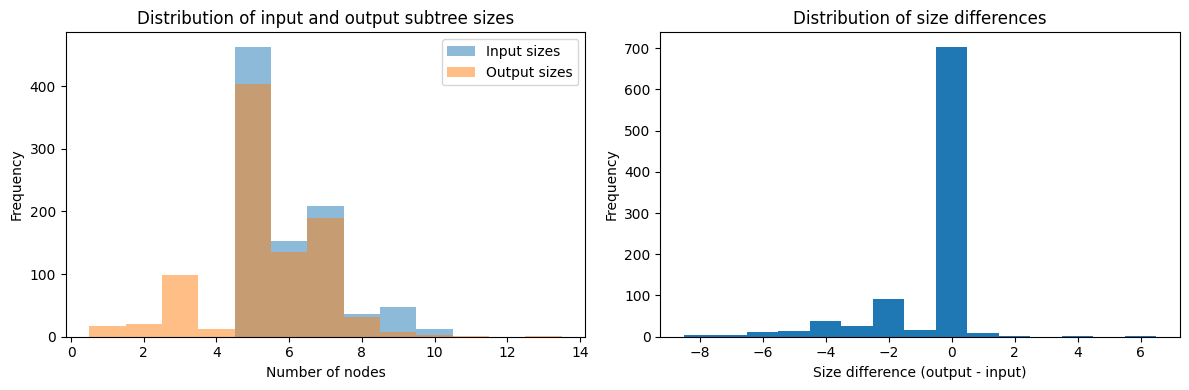

In [15]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot histograms of in and out sizes on first subplot
ax1.hist(in_sizes, alpha=0.5, label='Input sizes', bins=range(min(in_sizes), max(in_sizes)+2), align='left')
ax1.hist(out_sizes, alpha=0.5, label='Output sizes', bins=range(min(out_sizes), max(out_sizes)+2), align='left')
ax1.set_xlabel('Number of nodes')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of input and output subtree sizes')
ax1.legend()

# Plot histogram of differences on second subplot
differences = [out - in_ for out, in_ in zip(out_sizes, in_sizes)]
ax2.hist(differences, bins=range(min(differences), max(differences)+2), align='left')
ax2.set_xlabel('Size difference (output - input)')
ax2.set_ylabel('Frequency') 
ax2.set_title('Distribution of size differences')

plt.tight_layout()
plt.show()


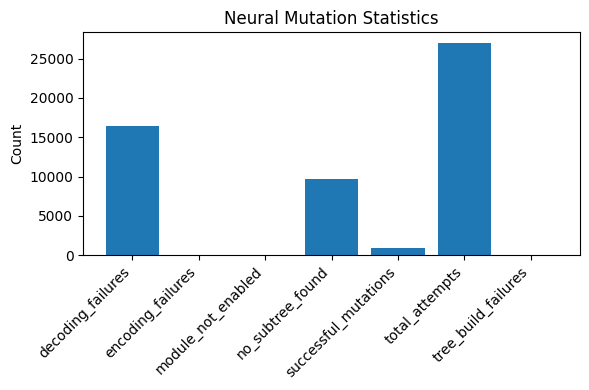

In [16]:
# Get counts for each stat type
count_stats = {k: v for k, v in stats.items() if isinstance(v, int)} 

# Create bar plot
plt.figure(figsize=(6, 4))
plt.bar(count_stats.keys(), count_stats.values())
plt.xticks(rotation=45, ha='right')
plt.title('Neural Mutation Statistics')
plt.ylabel('Count')
plt.tight_layout()
plt.show()